<a href="https://colab.research.google.com/github/flydragon2018/Analytics_Vidhya/blob/master/handwriting_recognition_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!unzip -q /content/drive/"My Drive"/handwriting/handWriting.zip 

In [3]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

In [4]:
pwd

'/content'

In [5]:
ls

drive/  hw_model.h5  hw_sub.csv  sample_data/  test/  train/  train.csv


In [6]:
train = pd.read_csv('train.csv')
#valid=train.sample(frac=0.1) 

maxlabel=int(train["label"].str.len().max())
print(maxlabel)

34


In [7]:
train.head()

,filename,label
0,0,BALTHAZAR
1,1,SIMON
2,2,BENES
3,3,LA LOVE
4,4,DAPHNE


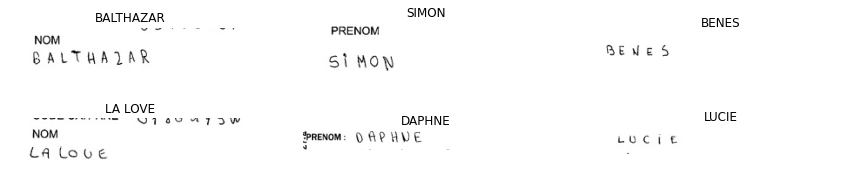

In [8]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'train/'+str(i)+".jpg"
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'label'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [9]:
print("Number of NaNs in train set      : ", train['label'].isnull().sum())
 


Number of NaNs in train set      :  643


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372331 entries, 0 to 372330
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   filename  372331 non-null  int64 
 1   label     371688 non-null  object
dtypes: int64(1), object(1)
memory usage: 5.7+ MB


In [11]:
train.dropna(axis=0, inplace=True)
 

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371688 entries, 0 to 372330
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   filename  371688 non-null  int64 
 1   label     371688 non-null  object
dtypes: int64(1), object(1)
memory usage: 8.5+ MB


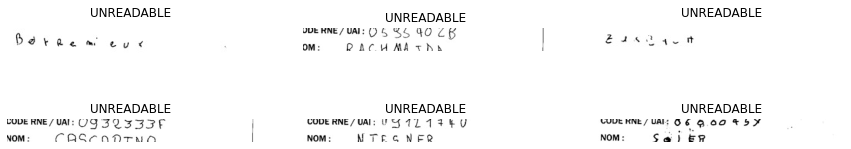

In [13]:
unreadable = train[train['label'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir =img_dir = 'train/'+str(unreadable.loc[i,"filename"])+".jpg"
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'label'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [14]:
train = train[train['label'] != 'UNREADABLE']
 

In [15]:
train['label'] = train['label'].str.upper()
 

In [16]:
train.reset_index(inplace = True, drop=True) 
 

In [17]:
def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [18]:
train_size = 40000
valid_size= 4000

print(train_size,valid_size)

40000 4000


In [19]:
!nvidia-smi

Sat Aug 29 04:11:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
train_x = []

for i in range(train_size):
    img_dir = 'train/'+str(train.loc[i, 'filename'])+".jpg"
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [21]:
valid_x =train_x[0:valid_size]

In [22]:
'''
valid_x =[]

for i in range(valid_size):
    img_dir = 'train/'+str(train.loc[i, 'filename'])+".jpg"
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)
'''

'\nvalid_x =[]\n\nfor i in range(valid_size):\n    img_dir = \'train/\'+str(train.loc[i, \'filename\'])+".jpg"\n    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)\n    image = preprocess(image)\n    image = image/255.\n    valid_x.append(image)\n'

In [23]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [24]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
 
max_str_len = int(maxlabel) # max length of input labels 34
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [25]:
name = 'DRAGON'
print(name, '\n',label_to_num(name))

DRAGON 
 [ 3 17  0  6 14 13]


In [26]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(str(train.loc[i, 'label']))
    train_y[i, 0:len(str(train.loc[i, 'label']))]= label_to_num(str(train.loc[i, 'label']))    


In [27]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(str(train.loc[i, 'label']))
    valid_y[i, 0:len(str(train.loc[i, 'label']))]= label_to_num(str(train.loc[i, 'label']))  

In [28]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 64, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 64, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 64, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 256, 64, 32)       0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 128, 32, 32)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 32, 64)       18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 32, 64)      

In [29]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [30]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [31]:
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001), metrics=['accuracy'])

model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, \
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),epochs=180, batch_size=128)

Epoch 1/180
313/313 [==============================] - 58s 186ms/step - loss: 23.1311 - accuracy: 0.0000e+00 - val_loss: 20.3387 - val_accuracy: 0.0000e+00
Epoch 2/180
313/313 [==============================] - 58s 184ms/step - loss: 20.0282 - accuracy: 0.0000e+00 - val_loss: 19.8816 - val_accuracy: 0.0000e+00
Epoch 3/180
313/313 [==============================] - 57s 183ms/step - loss: 19.5784 - accuracy: 0.0000e+00 - val_loss: 19.3553 - val_accuracy: 0.0000e+00
Epoch 4/180
313/313 [==============================] - 58s 184ms/step - loss: 18.9075 - accuracy: 0.0000e+00 - val_loss: 18.4744 - val_accuracy: 0.0000e+00
Epoch 5/180
313/313 [==============================] - 58s 185ms/step - loss: 17.7535 - accuracy: 0.0000e+00 - val_loss: 17.4233 - val_accuracy: 0.0000e+00
Epoch 6/180
313/313 [==============================] - 58s 185ms/step - loss: 16.2225 - accuracy: 0.0000e+00 - val_loss: 16.9008 - val_accuracy: 0.0000e+00
Epoch 7/180
313/313 [==============================] - 58s 186ms

In [32]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [34]:
y_true = train.loc[0:valid_size, 'label']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))


Correct characters predicted : 90.71%
Correct words predicted      : 89.90%


In [35]:
model.save('hw_model.h5')

In [41]:
test = os.listdir('test')
testnum=len(test)

sub=[]
for i in range(testnum):
    
    img_dir = 'test/'+test[i]
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
       
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    #print(decoded)
    sub.append([test[i][:-4],num_to_label(decoded[0])])
    print(i,test[i][:-4],num_to_label(decoded[0]) )
    
    #if i==10:
    #  break

df=pd.DataFrame(sub)
df.to_csv("hw_sub.csv",index=None,header=None)

Streaming output truncated to the last 5000 lines.
36371 25130 AUGUSTIN
36372 23260 SAUNIER
36373 13886 GIRY
36374 15825 JACQUES
36375 35774 KMHALLARDWILT
36376 23026 ENZO
36377 25977 BDJAGSET
36378 40194 LAVARRALECLERE
36379 27792 ELINA
36380 11605 LUCIE
36381 453 CANTOINE
36382 21558 GAUTIER
36383 9397 TINES
36384 15928 CHARLES
36385 14102 DI MAIO
36386 3977 ARNAUD
36387 3683 MINET
36388 1925 MHETREAU
36389 28576 POCEANE
36390 9123 KAREN
36391 36915 ALIZEE
36392 1328 JZOE
36393 6981 KHANIFI
36394 9331 CHEMACHI
36395 32734 BLACHE
36396 34301 CHARLETONT
36397 404 DE VANDEL
36398 12850 THIAN
36399 8450 MARIE
36400 38702 THOMASSIN
36401 11859 QOCEANE
36402 29673 NIAELLE
36403 29346 LE ESCON
36404 2187 DESRA
36405 14544 LIGONECHE
36406 5374 PHELISENDE
36407 27283 LOIC
36408 18977 CEMELINE
36409 28652 APOLLINE
36410 38857 DOUIS
36411 14626 LEMEI
36412 24083 DELANOE
36413 28207 PETRONE
36414 37664 TOUAREF
36415 4942 YNOEMIE
36416 2929 CEYO
36417 26547 EMILIE
36418 14661 GUIAS
36419 17555 MA

In [42]:
!cp hw_sub.csv /content/drive/"My Drive"/handwriting

In [ ]:
'''
train_x = []

for i in range(train_size,2*train_size):
    img_dir = 'train/'+str(train.loc[i, 'filename'])+".jpg"
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x2.append(image)

valid_x2 = []

for i in range(valid_size,2*valid_size):
    img_dir = 'train/'+str(train.loc[i, 'filename'])+".jpg"
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x2.append(image)

train_x2 = np.array(train_x2).reshape(-1, 256, 64, 1)
valid_x2 = np.array(valid_x2).reshape(-1, 256, 64, 1)

train_y2 = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size,2*train_size):
    train_label_len[i] = len(str(train.loc[i, 'label']))
    train_y2[i, 0:len(str(train.loc[i, 'label']))]= label_to_num(str(train.loc[i, 'label']))    

valid_y2 = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size,2*train_size):
    valid_label_len[i] = len(str(train.loc[i, 'label']))
    valid_y2[i, 0:len(str(train.loc[i, 'label']))]= label_to_num(str(train.loc[i, 'label']))  

model_final.fit(x=[train_x2, train_y2, train_input_len, train_label_len], y=train_output, \
                validation_data=([valid_x2, valid_y2, valid_input_len, valid_label_len], valid_output),epochs=120, batch_size=128)


'''